<a href="https://colab.research.google.com/github/dannyjammooa/LANL/blob/main/Two_and_four_qbits_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
pip install qiskit;

In [162]:
import numpy as np
import warnings
from tqdm.auto import tqdm
import qiskit as qk
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit import Aer, assemble
from qiskit.visualization import circuit_drawer, plot_histogram, plot_state_qsphere
from qiskit import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
pi = np.pi
%matplotlib inline

# Functions

## Measurement Functions

In [124]:
#Measurment Functions

#execute the circuit using qasm_simulator as backend
def execute_QC(quantum_circuit,shot):
  simulator = Aer.get_backend('qasm_simulator')
  result = execute(quantum_circuit, backend=simulator, shots=shot).result().get_counts()
  return result

#X-basis
def X_measurement(qc, qubit, cbit):
    """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
    qc.h(qubit)
    qc.measure(qubit, cbit)
    return qc

#Y-basis
def Y_measurement(qc, qubit, cbit):
   """Measure 'qubit' in the Y-basis, and store the result in 'cbit'"""
   qc.sdg(qubit)
   qc.h(qubit)
   qc.measure(qubit, cbit)
   return qc

#ZZ-basis
def ZZ_measurement(qc,qubit1,qubit2,cbit1,cbit2):
  qc.measure(qubit1,cbit1)
  qc.measure(qubit2,cbit2)
  return qc

#XX-basis
def XX_measurement(qc,qubit1,qubit2,cbit1,cbit2):
  qc.h(qubit1)
  qc.h(qubit2)
  qc.measure(qubit1,cbit1)
  qc.measure(qubit2,cbit2)
  return qc

#YY-basis
def YY_measurement(qc,qubit1,qubit2,cbit1,cbit2):
  qc.sdg(qubit1)
  qc.sdg(qubit2)
  qc.h(qubit1)
  qc.h(qubit2)
  qc.measure(qubit1,cbit1)
  qc.measure(qubit2,cbit2)
  return qc

#combinding all measurement into one function
def Measure(qc, basis, qubit1,qubit2,cbit1,cbit2):
  if basis == 'Z1':
    qc.measure([qubit1],[cbit1])
  elif basis =='Z2':
    qc.measure([qubit2],[cbit2])
  elif basis == 'Y':
    Y_measurement(qc,qubit1,cbit1)
  elif basis == 'X':
    X_measurement(qc,qubit1,cbit1)
  elif basis == 'ZZ':
    ZZ_measurement(qc, qubit1,qubit2,cbit1,cbit2)
  elif basis == 'YY':
    YY_measurement(qc, qubit1,qubit2,cbit1,cbit2)
  elif basis == 'XX':
    XX_measurement(qc, qubit1,qubit2,cbit1,cbit2)
  return qc

## Quantum Circuit and gate functions

In [125]:
#choosing our initial state
def Initial_State(quantum_circuit,IS,nqbits):
  if IS == 'odd': #skips odd numbered qubits
    for idx in range(nqbits):
      if idx%2 == 0: 
        continue
      else:
        quantum_circuit.x(idx)
  elif IS =='even': #skips odd numbered qubits
    for idx in range(nqbits):
      if idx%2 == 0: 
        quantum_circuit.x(idx)
      else:
        continue
  elif IS == 'alldown':
    for idx in range(nqbits):
      quantum_circuit.x(idx)
  elif IS =='allup':
    for idx in range(nqbits):
      quantum_circuit.id(idx)
  elif IS == '01':
    for idx in range(nqbits):
      if idx%2 == 0:
        quantum_circuit.h(idx)
        quantum_circuit.cx(idx,idx+1)
      else:
        quantum_circuit.x(idx)
  elif IS == '11':
    for idx in range(nqbits):
      quantum_circuit.x(idx)
      if idx%2 == 0:
        quantum_circuit.h(idx)
        quantum_circuit.cx(idx,idx+1)
      else:
        continue
  return quantum_circuit

#N(alpha,beta,gamma) gate from the paper
#Half time step
def SWAP1(var,t):
  Thalf = 0/5*t
  a = var[0]
  b = var[1]
  y = var[2]
  theta = pi/2 - 2*y*Thalf
  phi = 2*a*Thalf -pi/2
  lamda = pi/2 -2*b*Thalf
  qc = QuantumCircuit(2, name='Half')
  qc.rz(-pi/2,1)
  qc.cx(1,0)
  qc.rz(theta,0)
  qc.ry(phi,1)
  qc.cx(0,1)
  qc.ry(lamda,1)
  qc.cx(1,0)
  qc.rz(pi/2,0)
  return qc

#N(alpha,beta,gamma) gate from the paper
#Full time step
def SWAP2(var,t):
  a = var[0]
  b = var[1]
  y = var[2]
  theta = pi/2 - 2*y*t  #angle that depend on the zz two-body coefficient
  phi = 2*a*t -pi/2     #angle that depend on the xx two-body coefficient
  lamda = pi/2 -2*b*t   #angle that depend on the yy two-body coefficient
  qc = QuantumCircuit(2, name='Full')
  qc.rz(-pi/2,1)
  qc.cx(1,0)
  qc.rz(theta,0)
  qc.ry(phi,1)
  qc.cx(0,1)
  qc.ry(lamda,1)
  qc.cx(1,0)
  qc.rz(pi/2,0)
  return qc

#The full unitary time evolution 
def Unitary(quantum_circuit,var,nqbits,h,t):
  Thalf = 0.5*t
  psi = h*Thalf  #angle that depends on the z one-body coefficient
  #one-body term
  for idx in range(nqbits):
    quantum_circuit.rz(psi,idx) 
  quantum_circuit.barrier()
  #two-body term / odd qubits swaped/ half time step
  for idx in range(nqbits):
    if idx%2 == 0:
      continue
    else:
      if idx == nqbits-1:
        break
      else:
        quantum_circuit.append(SWAP1(var,t), [idx,idx+1])
  #two-body term / even qubits swaped/ full time step
  for idx in range(nqbits):
    if idx%2 == 1:
      continue
    else:
      if idx == nqbits:
        break
      else:
        quantum_circuit.append(SWAP2(var,t), [idx,idx+1])
  #two-body term / odd qubits swaped/ half time step
  for idx in range(nqbits):
    if idx%2 == 0:
      continue
    else:
      if idx == nqbits-1:
        break
      else:
        quantum_circuit.append(SWAP1(var,t), [idx,idx+1])
  quantum_circuit.barrier()
  #one-body term
  for idx in range(nqbits):
    quantum_circuit.rz(psi,idx) 
  return quantum_circuit

#applies trotter steps
def Trotter(quantum_circuit, numTstep, nqbits, var, h, t):
  for i in range(numTstep):
      Unitary(quantum_circuit, var, nqbits, h, t)
  return quantum_circuit

#creates our quantum Circuit
def Quantum_Circuit(IS,nqbits, var, numTstep,h,t):
     QC = QuantumCircuit(nqbits)
     Initial_State(QC,IS,nqbits)
     QC.barrier()
     Trotter(QC,numTstep,nqbits,var,h,t)
     return QC

#creates/measures/excute our quantum circuit and stores the probabilies of measured circuit
def Results(IS,nqbits,numTstep,basis,var,shots,h,t):
  Energy = []
  for initialstate in IS:
    E = []
    qc = Quantum_Circuit(initialstate,nqbits,var,numTstep,h,t)
    for measure_circuit in basis:
      QQ = QuantumCircuit(nqbits,2)
      QX = qc+Measure(QQ, measure_circuit,0,1,0,1)
      counts = execute_QC(QX,shots)
      probs = {}
      for output in ['00','01', '10', '11']:
        if output in counts:
          probs[output] = counts[output]/shots
        else:
          probs[output] = 0
      E.append(probs['00']-probs['01']-probs['10']+probs['11'])
    Energy.append(E)
  return Energy

def Results2(IS,nqbits,numTstep,basis,var,shots,h,t):
  prob00 = []
  prob01 = []
  prob10 = []
  prob11 = []
  qc = Quantum_Circuit(IS,nqbits,var,numTstep,h,t)
  for measure_circuit in basis:
    QQ = QuantumCircuit(nqbits,2)
    QX = qc+Measure(QQ, measure_circuit,0,1,0,1)
    counts = execute_QC(QX,shots)
    probs = {}
    for output in ['00','01', '10', '11']:
      if output in counts:
        probs[output] = counts[output]/shots
      else:
        probs[output] = 0
    prob00.append(probs['00'])
    prob10.append(probs['01'])
    prob01.append(probs['10'])
    prob11.append(probs['11'])
  return prob00, prob01, prob10, prob11

# Two qbit System

Consider the two qbit Hamiltonian:

\begin{equation}
   H = A \sigma_0 \cdot \sigma_1 + B (\sigma_{0}^z + \sigma_1^z),
\end{equation}
where $\sigma_0 \cdot \sigma_1 = 
\sigma_0^x \sigma_1^x + 
\sigma_0^y \sigma_1^y + 
\sigma_0^z \sigma_1^z  $.
This is a simplification of Eq. 3 in the paper by Smith, Kin, Pollman, and Knolle.
The eigenstates of this Hamiltonian and their energies are:
\begin{eqnarray}
 \Psi_{1,-1} &= | 0 0 \rangle & E = A - 2 B \nonumber \\
\Psi_{1,0} &= (| 0 1 \rangle + | 1 0 \rangle)/\sqrt{2} & E = A \nonumber \\
\Psi_{1,1} & = (| 1 1 \rangle ) & E = A + 2 B \nonumber \\
\Psi_{0,0} & = (| 0 1 \rangle - | 1 0 \rangle)/\sqrt{2} & E = -3 A .
\end{eqnarray}
I am using the convention $\sigma_z |1 \rangle  = | 1 \rangle,
\sigma_z | 0 \rangle = - | 0 \rangle $.
If I start with a state with both down or both up states, 
they remain the same except for a phase with time evolution.  
\begin{equation}
\exp [ - i H \delta t] | 1 1 \rangle = \exp [ - i (A+2B) \delta t] | 1 1 \rangle
\end{equation}.
However if I take an initial state $ | 1 0 \rangle$, for example,
this is a linear  combination of eigenstates:
\begin{equation}
| 1 0 \rangle = ( 1/ \sqrt{2}) (\Psi_{1,0} - \Psi_{0,0})
\end{equation}
Then the time evolved state is the sum of two components with different
energies:
\begin{equation}
\exp [-i H \delta t] | 1 0 \rangle = 
[  \exp[ -i A \delta t ] \Psi_{1,0} / \sqrt{2}
- \exp[ + i 3A \delta t ] \Psi_{0,0} / \sqrt{2} ].
\end{equation}
The expectation value of any operator like $\sigma_0^z, \sigma_1^z,
\sigma_0 \cdot \sigma_1$ will oscillate with the frequency of the
difference between the energy of the two state which is 4 A.
The total energy should still be constant and for this initial state
be equal to the average of the two states $(A - 3A)/2 = -A$.



## Calculating Energy

---



In [159]:
Energy = []
Shots= 10000 #number of shots
qbit = 2 #size of circuit
trotter = 1 #number of trotter steps
t= 0.1 #time
basis = ['Z1','Z2','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['allup','01','alldown','11']
E = Results(PSI,qbit,trotter,basis,Var,Shots,B,t)
for IS in PSI:
  if IS == 'allup':
    Energy.append(-B*(E[0][0]+E[0][1])+A*(E[0][2]+E[0][3]+E[0][4]))
  elif IS == '01':
    Energy.append(0*(E[1][0]+E[1][1])+A*(E[1][2]+E[1][3]+E[1][4])) 
  elif IS == 'alldown':
    Energy.append(-B*(E[2][0]+E[2][1])+A*(E[2][2]+E[2][3]+E[2][4])) 
  elif IS == '11':
    Energy.append(0*(E[3][0]+E[3][1])+A*(E[3][2]+E[3][3]+E[3][4])) 
print('PSI_1,-1:','Analytical solution E=',A-2*B,'Quantum Simulation E =',Energy[0])
print('PSI_1,0:','Analytical solution E=',A,'Quantum Simulation E =',Energy[1])
print('PSI_1,1:','Analytical solution E=',A+2*B,'Quantum Simulation E =',Energy[2])
print('PSI_0,0:','Analytical solution E=',-3*A,'Quantum Simulation E =',Energy[3])

PSI_1,-1: Analytical solution E= 0.4 Quantum Simulation E = 0.39060000000000006
PSI_1,0: Analytical solution E= 1 Quantum Simulation E = 1.0
PSI_1,1: Analytical solution E= 1.6 Quantum Simulation E = 1.5983999999999998
PSI_0,0: Analytical solution E= -3 Quantum Simulation E = -3.0


## Statevector and trotter steps given the $|10\rangle$ initial State

In [127]:
from qiskit.quantum_info import Statevector
from qiskit import Aer
backend = Aer.get_backend('statevector_simulator')
from qiskit.visualization import plot_state_city

### plotting the swap

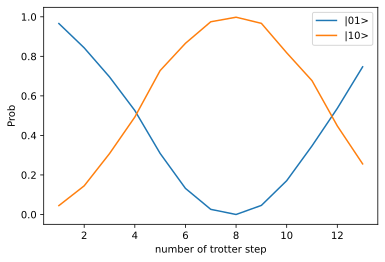

In [128]:
tTrotter = np.arange(1,14,1)
State01 = []
State10 = []
for i in range(len(tTrotter)):
  Res = Results2('odd',qbit,tTrotter[i],basis,Var,1000,B,t)
  State01.append(Res[1])
  State10.append(Res[2])

ss01 = []
ss10 = []
for i in range(13):
  ss01.append(State01[i][1])
  ss10.append(State10[i][0])


plt.plot(tTrotter,ss01,label='|01>')
plt.plot(tTrotter,ss10,label='|10>')
plt.ylabel('Prob')
plt.xlabel('number of trotter step')
plt.legend()

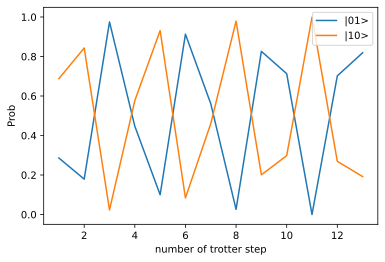

In [129]:
tTrotter = np.arange(1,14,1)
State01 = []
State10 = []
T = 0.5
for i in range(len(tTrotter)):
  Res = Results2('odd',qbit,tTrotter[i],basis,Var,1000,B,T)
  State01.append(Res[1])
  State10.append(Res[2])

ss01 = []
ss10 = []
for i in range(13):
  ss01.append(State01[i][1])
  ss10.append(State10[i][0])


plt.plot(tTrotter,ss01,label='|01>')
plt.plot(tTrotter,ss10,label='|10>')
plt.ylabel('Prob')
plt.xlabel('number of trotter step')
plt.legend()

### Statevector for Small Time Step

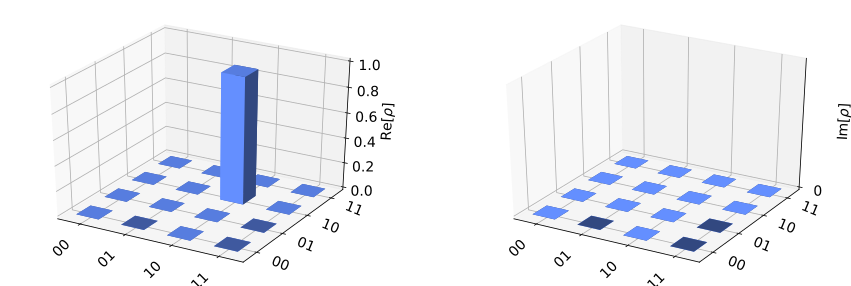

In [130]:
QCI = QuantumCircuit(2)
QCI.x(1)
plot_state_city(QCI)

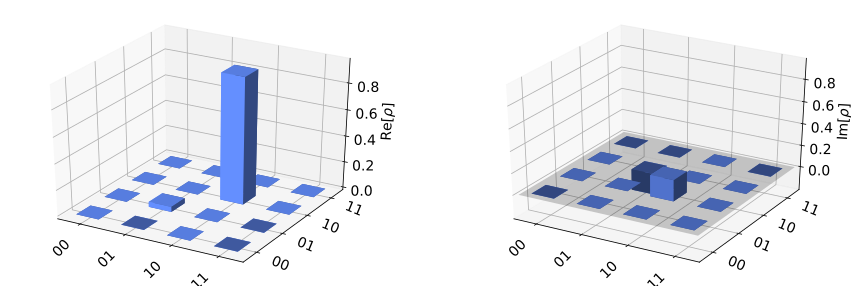

In [131]:
#same circuit as above, plotting the state vector
#1 trotter step
QC = Quantum_Circuit('odd',2,Var,1,B,t)
plot_state_city(QC)

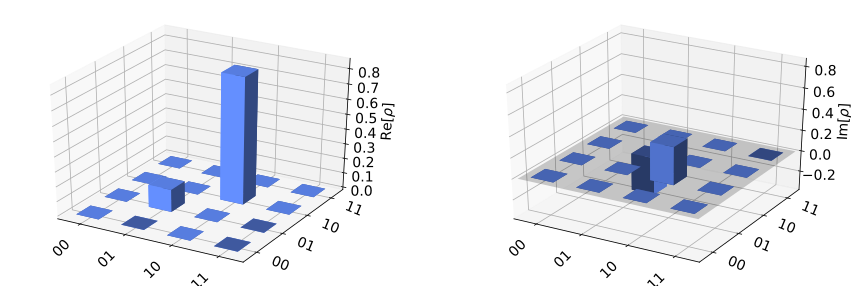

In [132]:
#2 trotter step 
QC2 = Quantum_Circuit('odd',2,Var,2,B,t)
plot_state_city(QC2)

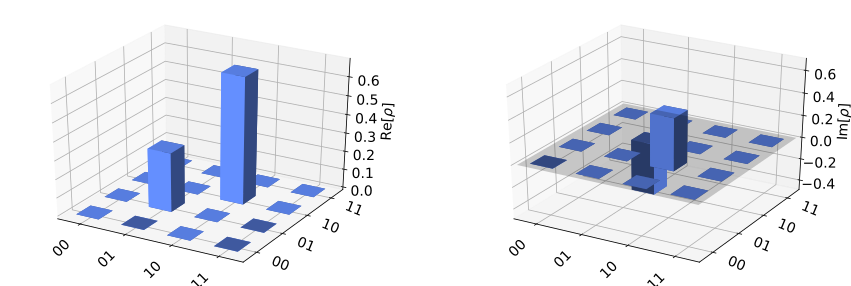

In [133]:
# 3 trotter step
QC3 = Quantum_Circuit('odd',2,Var,3,B,t)
plot_state_city(QC3)

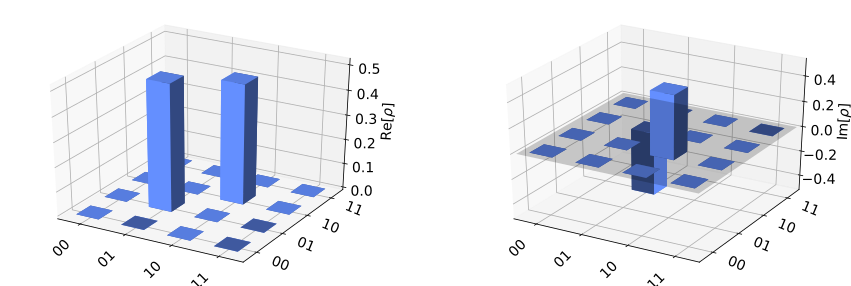

In [134]:
# 4 trotter step
QC4 = Quantum_Circuit('odd',2,Var,4,B,t)
plot_state_city(QC4)

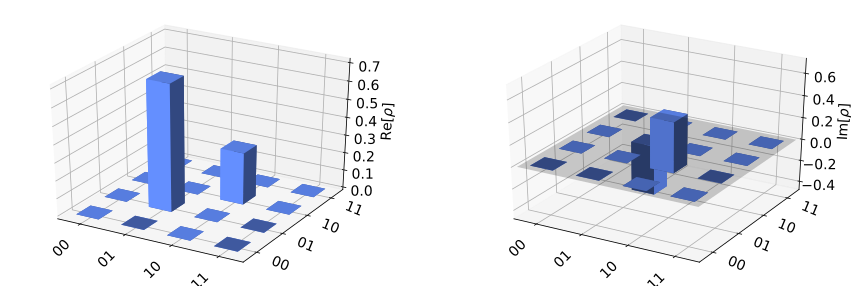

In [135]:
# 5 trotter step
QC5 = Quantum_Circuit('odd',2,Var,5,B,t)
plot_state_city(QC5)

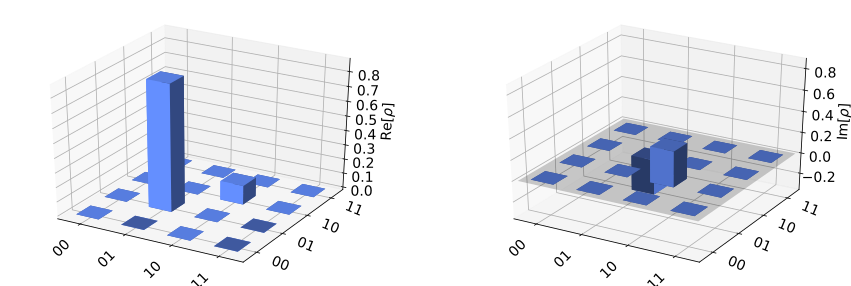

In [136]:
# 6 trotter step
QC6 = Quantum_Circuit('odd',2,Var,6,B,t)
plot_state_city(QC6)

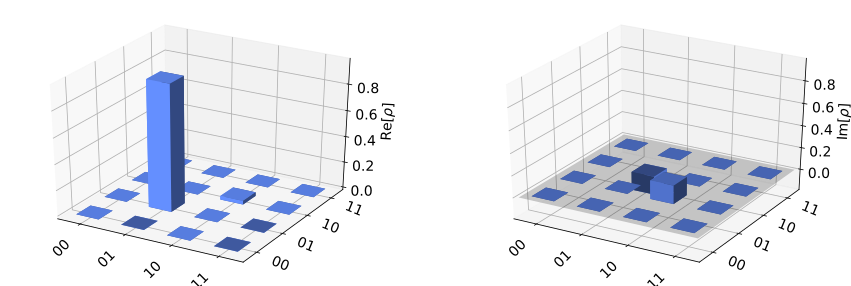

In [137]:
# 7 trotter step
QC7 = Quantum_Circuit('odd',2,Var,7,B,t)
plot_state_city(QC7)

### Statevector for Larger time step

          
q_0: ─────
     ┌───┐
q_1: ┤ X ├
     └───┘


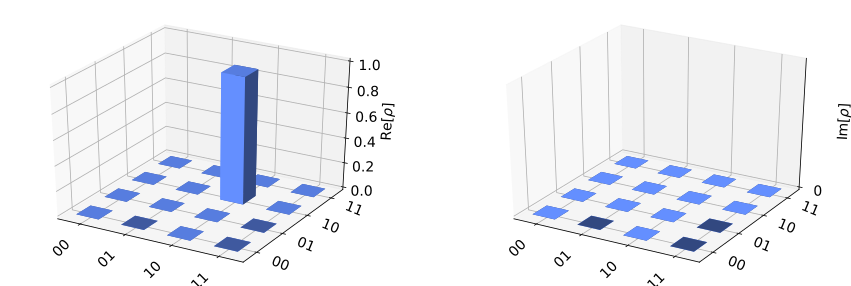

In [138]:
QCT = QuantumCircuit(2)
QCT.x(1)
print(QCT.draw())
plot_state_city(QCT)

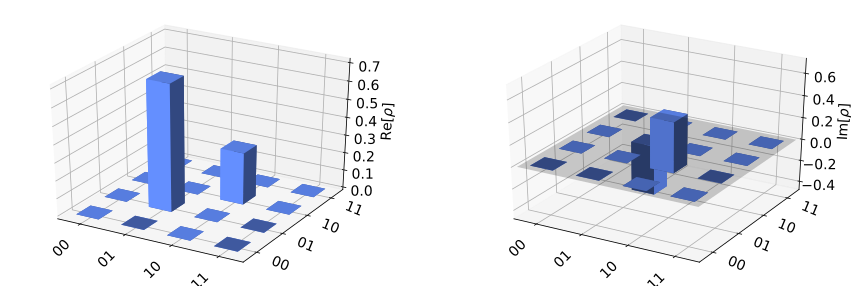

In [139]:
T = 0.5
QCT1 = Quantum_Circuit('odd',2,Var,1,B,T)
plot_state_city(QCT1)

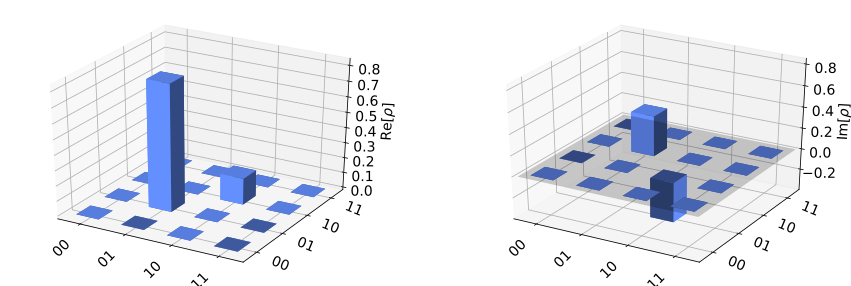

In [140]:
QCT2 = Quantum_Circuit('odd',2,Var,2,B,T)
plot_state_city(QCT2)

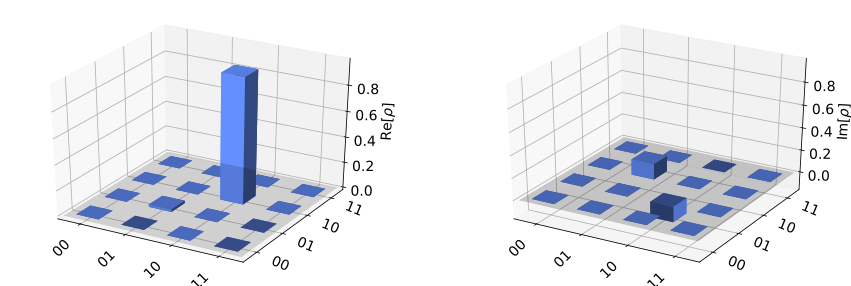

In [141]:
QCT3 = Quantum_Circuit('odd',2,Var,3,B,T)
plot_state_city(QCT3)

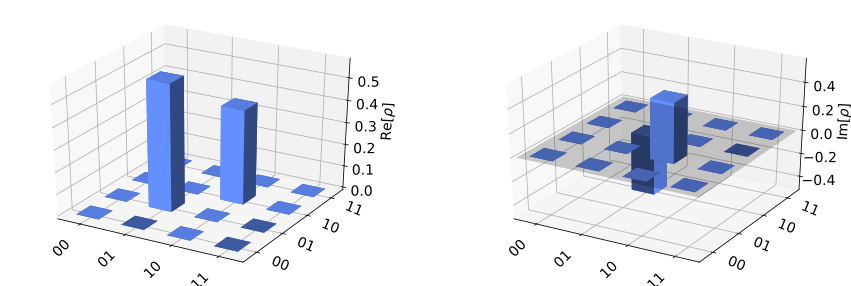

In [142]:
QCT4 = Quantum_Circuit('odd',2,Var,4,B,T)
plot_state_city(QCT4)

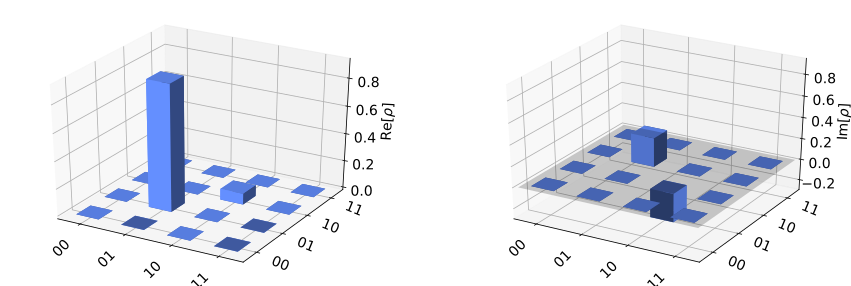

In [143]:
QCT5 = Quantum_Circuit('odd',2,Var,5,B,T)
plot_state_city(QCT5)

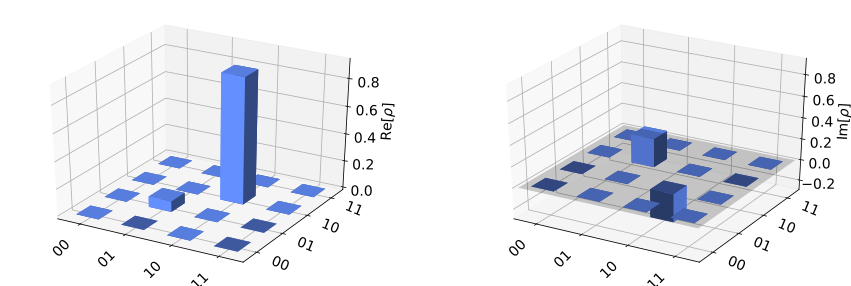

In [144]:
QCT6 = Quantum_Circuit('odd',2,Var,6,0.3,T)
plot_state_city(QCT6)

#Four qbit System

## Calculating Energy

In [145]:
Energy = []
Shots= 10000 #number of shots
qbit = 4 #size of circuit
trotter = 1 #number of trotter steps
t= 0.1 #time
basis = ['Z1','Z2','ZZ','XX','YY'] #measures the circuit given said basis
A = 1 #the two-body constant A 
B = 0.3 #the one-body constant B 
Var = np.array([A,A,A]) #since alpha=beta=gamma=A in this problem
PSI = ['odd','even','allup','01','alldown','11']
E = Results(PSI,qbit,trotter,basis,Var,Shots,B,t)

for IS in PSI:
  if IS == 'odd':
    Energy.append(-B*(E[0][0]+E[0][1])+A*(E[0][2]+E[0][3]+E[0][4]))
  elif IS == 'even':
    Energy.append(-B*(E[1][0]+E[1][1])+A*(E[1][2]+E[1][3]+E[1][4]))
  elif IS == 'allup':
    Energy.append(-B*(E[2][0]+E[2][1])+A*(E[2][2]+E[2][3]+E[2][4]))
  elif IS == '01':
    Energy.append(0*(E[3][0]+E[3][1])+A*(E[3][2]+E[3][3]+E[3][4])) 
  elif IS == 'alldown':
    Energy.append(-B*(E[4][0]+E[4][1])+A*(E[4][2]+E[4][3]+E[4][4])) 
  elif IS == '11':
    Energy.append(0*(E[5][0]+E[5][1])+A*(E[5][2]+E[5][3]+E[5][4])) 
print('Quantum Simulation E =',Energy[0])
print('Quantum Simulation E =',Energy[1])
print('Quantum Simulation E =',Energy[2])
print('Quantum Simulation E =',Energy[3])
Quantum_Circuit('odd',4,Var,trotter,B,t).draw() #only drawing the |0101> IS

Quantum Simulation E = -1.00266
Quantum Simulation E = -0.9886799999999999
Quantum Simulation E = 0.41920000000000013
Quantum Simulation E = 1.0


░ ┌───────────┐ ░          ┌───────┐          ░ ┌───────────┐
q_0: ──────░─┤ Rz(0.015) ├─░──────────┤0      ├──────────░─┤ Rz(0.015) ├
     ┌───┐ ░ ├───────────┤ ░ ┌───────┐│  Full │┌───────┐ ░ ├───────────┤
q_1: ┤ X ├─░─┤ Rz(0.015) ├─░─┤0      ├┤1      ├┤0      ├─░─┤ Rz(0.015) ├
     └───┘ ░ ├───────────┤ ░ │  Half │├───────┤│  Half │ ░ ├───────────┤
q_2: ──────░─┤ Rz(0.015) ├─░─┤1      ├┤0      ├┤1      ├─░─┤ Rz(0.015) ├
     ┌───┐ ░ ├───────────┤ ░ └───────┘│  Full │└───────┘ ░ ├───────────┤
q_3: ┤ X ├─░─┤ Rz(0.015) ├─░──────────┤1      ├──────────░─┤ Rz(0.015) ├
     └───┘ ░ └───────────┘ ░          └───────┘          ░ └───────────┘

## Statevector given $|0101\rangle$ IS

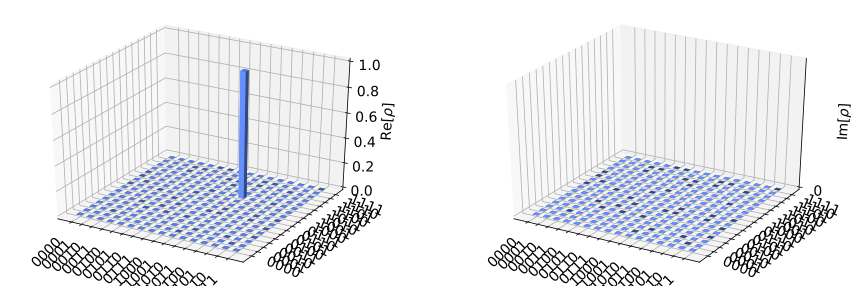

In [146]:
QCI = QuantumCircuit(4)
QCI.x(1)
QCI.x(3)
plot_state_city(QCI)

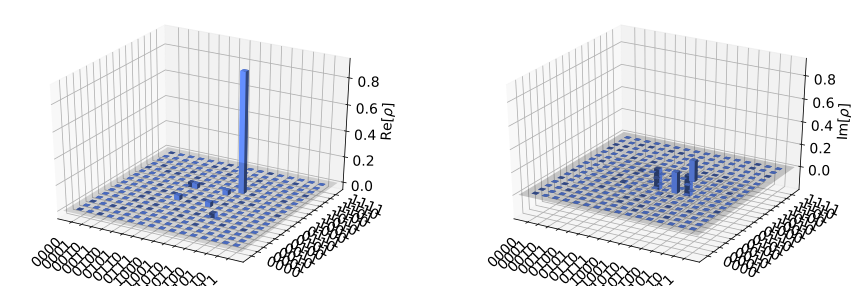

In [147]:
#same circuit as above, plotting the state vector
#1 trotter step
QC = Quantum_Circuit('odd',4,Var,1,B,t)
plot_state_city(QC)

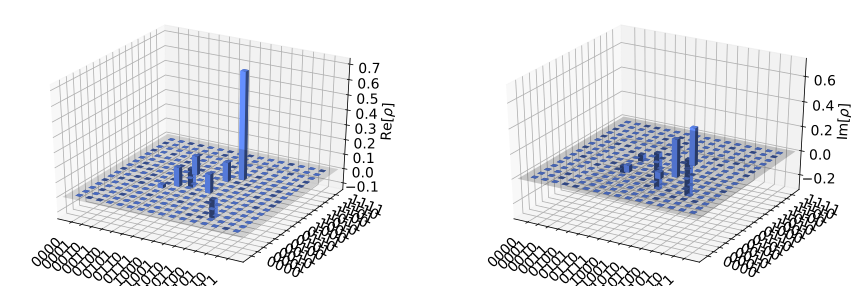

In [148]:
#same circuit as above, plotting the state vector
#2 trotter step
QC2 = Quantum_Circuit('odd',4,Var,2,B,t)
plot_state_city(QC2)

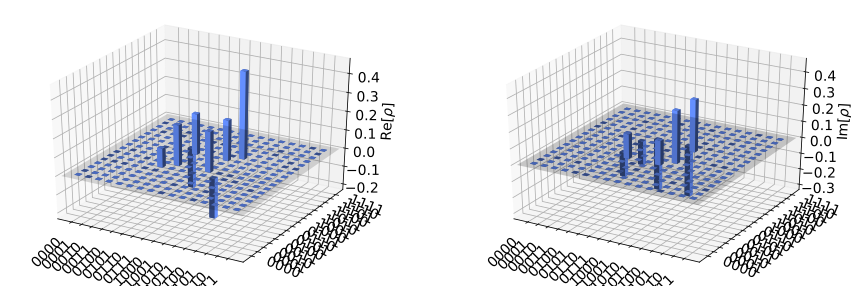

In [149]:
#same circuit as above, plotting the state vector
#3 trotter step
QC3 = Quantum_Circuit('odd',4,Var,3,B,t)
plot_state_city(QC3)

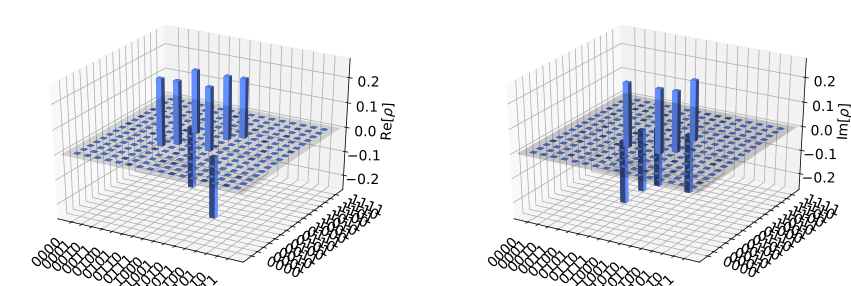

In [150]:
#same circuit as above, plotting the state vector
#4 trotter step
QC4 = Quantum_Circuit('odd',4,Var,4,B,t)
plot_state_city(QC4)

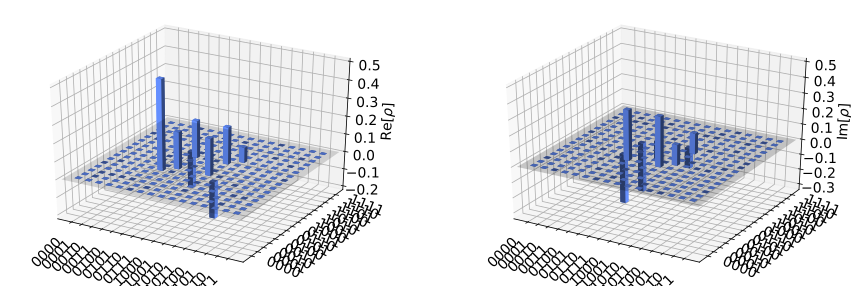

In [151]:
#same circuit as above, plotting the state vector
#5 trotter step
QC5 = Quantum_Circuit('odd',4,Var,5,B,t)
plot_state_city(QC5)

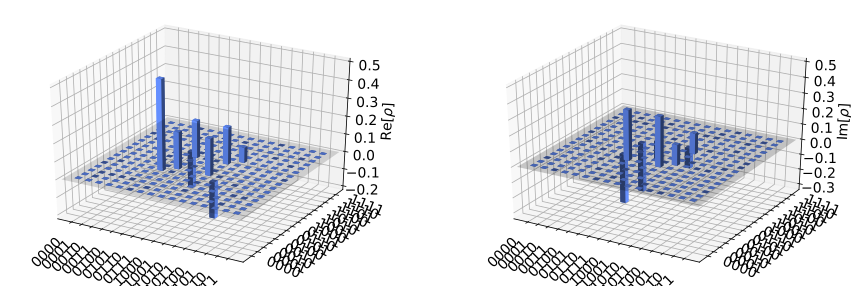

In [152]:
#same circuit as above, plotting the state vector
#6 trotter step
QC6 = Quantum_Circuit('odd',4,Var,5,6,t)
plot_state_city(QC6)

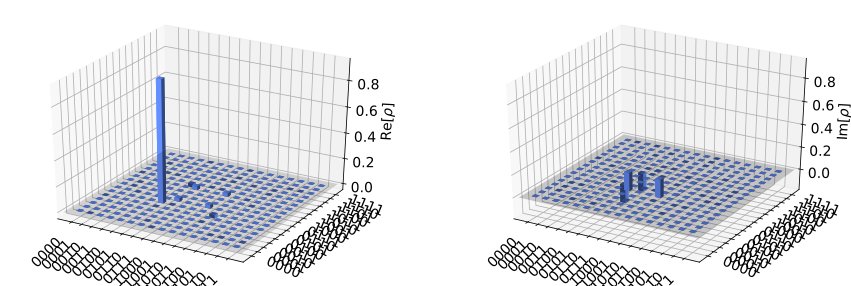

In [153]:
#same circuit as above, plotting the state vector
#7 trotter step
QC7 = Quantum_Circuit('odd',4,Var,7,B,t)
plot_state_city(QC7)